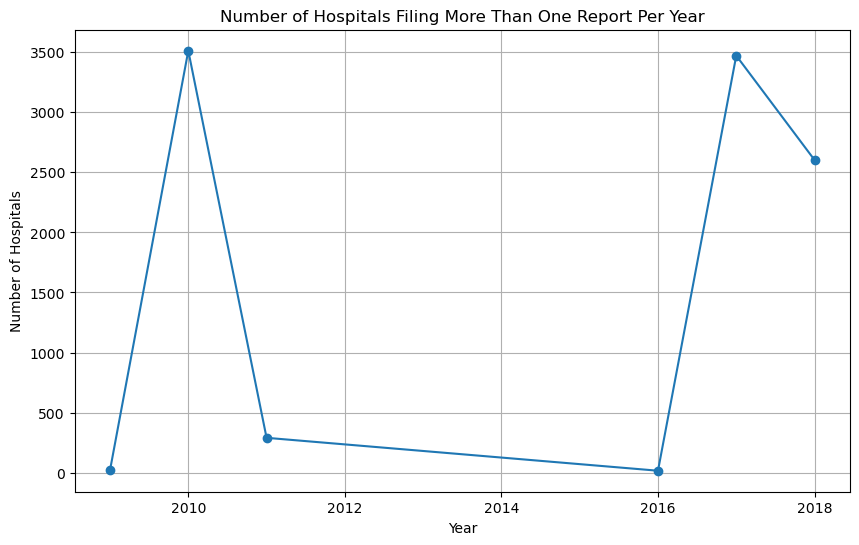

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

#reading data
hcris = pd.read_csv('../../data/Output/HCRIS.csv')
# Filter data to get hospitals with more than one report in the same year
duplicate_hospitals = hcris[hcris.duplicated(subset=['provider_number', 'fyear'], keep=False)]

# Count unique hospitals that filed more than one report per year
hospitals_over_time = duplicate_hospitals.groupby('fyear')['provider_number'].nunique()

# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(hospitals_over_time.index, hospitals_over_time.values, marker='o')
plt.title("Number of Hospitals Filing More Than One Report Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Hospitals")
plt.grid(True)
plt.show()




Index(['report', 'provider_number', 'npi', 'fy_start', 'fy_end',
       'date_processed', 'date_created', 'status', 'year', 'beds',
       'tot_charges', 'tot_discounts', 'tot_operating_exp', 'ip_charges',
       'icu_charges', 'ancillary_charges', 'tot_discharges',
       'mcare_discharges', 'mcaid_discharges', 'tot_mcare_payment',
       'secondary_mcare_payment', 'street', 'city', 'state', 'zip', 'county'],
      dtype='object')
